# Code to determine battery operation scheduling based on 2019 forecasted demand from stlf model

In [1]:
#import packages
import numpy as np
import pandas as pd
import cvxpy as cp
import gurobipy
from datetime import datetime, time, date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import Counter

# Data pre-processing

In [2]:
#Add date parser to read in the date as an actual date object
date_parser = lambda x: datetime.strptime(x, '%d-%b-%Y')
demand = pd.read_csv('./data/ColumbiaDemand.csv', parse_dates=['Date'], date_parser=date_parser) 
demand.head()
#Restructure into one list of demands for each month

,Date,TotalDemand [kWh],Period01 [kWh],Period02 [kWh],Period03 [kWh],Period04 [kWh],Period05 [kWh],Period06 [kWh],Period07 [kWh],Period08 [kWh],...,Period87 [kWh],Period88 [kWh],Period89 [kWh],Period90 [kWh],Period91 [kWh],Period92 [kWh],Period93 [kWh],Period94 [kWh],Period95 [kWh],Period96 [kWh]
0,2018-01-01,72686.88,734.40,731.52,727.20,735.84,730.08,728.64,731.52,730.08,...,740.16,741.60,734.40,735.84,735.84,730.08,725.76,731.52,728.64,724.32
1,2018-01-02,73594.08,728.64,727.20,728.64,727.20,732.96,734.40,734.40,737.28,...,743.04,741.60,741.60,738.72,750.24,743.04,750.24,738.72,738.72,743.04
2,2018-01-03,73440.00,745.92,743.04,745.92,744.48,741.60,734.40,735.84,734.40,...,734.40,732.96,721.44,714.24,721.44,725.76,727.20,724.32,731.52,722.88
3,2018-01-04,73967.04,718.56,718.56,724.32,727.20,720.00,724.32,725.76,720.00,...,747.36,744.48,735.84,734.40,741.60,743.04,738.72,741.60,740.16,735.84
4,2018-01-05,74625.12,745.92,743.04,744.48,741.60,737.28,743.04,747.36,748.80,...,767.52,768.96,760.32,758.88,756.00,756.00,753.12,754.56,750.24,745.92


In [3]:
#Drop total demand columns and pivot
demand_unpivoted = demand[demand.columns.difference(['TotalDemand [kWh]'])].melt(id_vars=['Date'], var_name='period', value_name='demand')
#Make sure to sore by date and period
demand_unpivoted = demand_unpivoted.sort_values(by=['Date','period']).reset_index(drop=True)
demand_unpivoted['year'] = demand_unpivoted['Date'].dt.year
demand_unpivoted['month'] = demand_unpivoted['Date'].dt.month
demand_unpivoted['weekday'] = demand_unpivoted['Date'].dt.weekday
demand_unpivoted = demand_unpivoted.fillna(0)
demand_unpivoted.head() 

,Date,period,demand,year,month,weekday
0,2018-01-01,Period01 [kWh],734.40,2018,1,0
1,2018-01-01,Period02 [kWh],731.52,2018,1,0
2,2018-01-01,Period03 [kWh],727.20,2018,1,0
3,2018-01-01,Period04 [kWh],735.84,2018,1,0
4,2018-01-01,Period05 [kWh],730.08,2018,1,0


In [4]:
date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
forecast = pd.read_csv('./data/forecasted_demand.csv', parse_dates=['interval'], date_parser=date_parser, index_col='Unnamed: 0') 
forecast_2019 = forecast[forecast['interval'] >= datetime(2019, 1, 1)].reset_index(drop=True)
forecast_2019['month'] = forecast_2019['interval'].dt.month
forecast_2019.head()

,interval,data,forecast,month
0,2019-01-01 00:00:00,666.72,686.802478,1
1,2019-01-01 00:15:00,665.28,687.262579,1
2,2019-01-01 00:30:00,679.68,691.316724,1
3,2019-01-01 00:45:00,676.80,690.248117,1
4,2019-01-01 01:00:00,681.12,686.298023,1


## Optimize using Forecasted Demand for 2019:

In [15]:
def run_optimization(D, P, battery, month, e_0):
    """
    Description: Code to run the optimization procedure

    Inputs:
        D, np.array: demand for each period
        P, float: battery power rating
        battery, str : battery option either "li-ion" or "thermal"
        month, int: month of year
        e_0, float: energy stored in the battery and the start of the month
    
    Output:
        Results of optimization
    """
    #Update variables depending on battery type
    if battery == 'li-ion':
        #battery efficiency
        eta = .95
        #Energy rating
        E = 4*P
        #Define additional variables
        cost_P = 300*P
        cost_E = 200*E

    elif battery == 'thermal':
        #battery efficiency
        eta = .7
        #Energy rating
        E = 12*P
        #Define additional variables
        cost_P = 500*P
        cost_E = 50*E

    else:
        print('optimizing without battery...')
        P=0
        eta = .95
        E = 0
        cost_P = 0
        cost_E = 0
    
    #Update peak charges depending on time of year:
    if month in [6, 7, 8, 9]:
        B = 9.15 + 18.44 + 16.66
    else:
        B = 4.21 + 13.96
        
    #Cost of electricity
    C = .13
    
    # Decision Variables
    #Storage discharge power
    d = cp.Variable(len(D), nonneg=True)
    # Storage charge power
    q = cp.Variable(len(D), nonneg=True)
    # Energy storged
    e = cp.Variable(len(D), nonneg=True)
    # peak demand
    p = cp.Variable(nonneg=True)

    # Initialize an empty constraint set
    con_set_1 = []  

    for t in range(len(D)):
        #These if statements relate to if a charge/discharge is provided
        #Can't discharge more than the power rating of battery
        con_set_1.append(d[t] <= .25*P)
        #Can't charge more than the power rating of battery
        con_set_1.append(q[t] <= .25*P)
        # #Can't store more energy than capacity
        con_set_1.append(e[t] <= E)
        if t == 0:
            # state-of charge constraint 1 - use final state-of-energy
            # from previous month
            con_set_1.append(e[t] - e_0 == q[t]*eta - d[t]/eta)
        elif t == len(D)-1:
            # # peak demand identification
            con_set_1.append(p >= D[t] - d[t] + q[t])
        else:
            # # state-of charge constraint 1
            con_set_1.append(e[t] - e[t-1] == q[t]*eta - d[t]/eta)
            # # peak demand identification
            con_set_1.append(p >= D[t] - d[t] + q[t] + D[t+1] - d[t+1] + q[t+1])

    #Define Objective - BP + sum over t
    #mutlipy by 2 because p is only a half hour increment right now
    obj = cp.Minimize(2*B*p + C*sum(D - d + q))

    # Solve the problem
    prob1 = cp.Problem(obj, con_set_1)
    prob1.solve(solver = "GUROBI", reoptimize=True)

    return(prob1.value, cost_E, cost_P, e, p, d, q)
    
def run_optimization_actual_demand(D, P, battery, month, e_0, d, q):
    """
    Description: Code to run the optimization procedure with pre-defined battery operations

    Inputs:
        D, np.array: demand for each period
        P, float: battery power rating
        battery, str : battery option either "li-ion" or "thermal"
        month, int: month of year
        e_0, float: energy stored in the battery and the start of the month
        d, np.array: battery discharge for each period
        q, np.array: battery charge for each period
    
    Output:
        Results of optimization
    """
    #Update variables depending on battery type
    if battery == 'li-ion':
        #battery efficiency
        eta = .95
        #Energy rating
        E = 4*P
        #Define additional variables
        cost_P = 300*P
        cost_E = 200*E

    elif battery == 'thermal':
        #battery efficiency
        eta = .7
        #Energy rating
        E = 12*P
        #Define additional variables
        cost_P = 500*P
        cost_E = 50*E

    else:
        print('optimizing without battery...')
        P=0
        eta = 1
        E = 0
        cost_P = 0
        cost_E = 0
    
    #Update peak charges depending on time of year:
    if month in [6, 7, 8, 9]:
        B = 9.15 + 18.44 + 16.66
    else:
        B = 4.21 + 13.96
        
    #Cost of electricity
    C = .13
    
    # Decision Variables
    #Storage discharge power
    # d = cp.Variable(len(D), nonneg=True)
    # Storage charge power
    # q = cp.Variable(len(D), nonneg=True)
    # Energy storged
    e = cp.Variable(len(D), nonneg=True)
    # peak demand
    p = cp.Variable(nonneg=True)

    # Initialize an empty constraint set
    con_set_1 = []  

    for t in range(len(D)):
        #These if statements relate to if a charge/discharge is provided
        #Can't discharge more than the power rating of battery
        # con_set_1.append(d[t] <= P)
        #Can't charge more than the power rating of battery
        # con_set_1.append(q[t] <= P)
        # #Can't store more energy than capacity
        con_set_1.append(e[t] <= E)
        if t == 0:
            # state-of charge constraint 1 - assume battery is empty
            # before month starts
            con_set_1.append(e[t] - e_0 == q[t]*eta - d[t]/eta)
        elif t == len(D)-1:
            # # peak demand identification
            con_set_1.append(p >= D[t] - d[t] + q[t])
        else:
            # # state-of charge constraint 1
            con_set_1.append(e[t] - e[t-1] == q[t]*eta - d[t]/eta)
            # # peak demand identification
            con_set_1.append(p >= D[t] - d[t] + q[t] + D[t+1] - d[t+1] + q[t+1])

    #Define Objective - BP + sum over t
    #mutlipy by 2 because p is only a half hour increment right now
    obj = cp.Minimize(2*B*p + C*sum(D - d + q))

    # Solve the problem
    prob1 = cp.Problem(obj, con_set_1)
    prob1.solve(solver = "GUROBI", reoptimize=True)

    return(prob1.value, cost_E, cost_P, e, p, d, q)

In [17]:
discharge = np.array([])
charge = np.array([])
monthly_values_2019 = pd.DataFrame(columns=['month', 'forecasted_or_actual', 'operation_cost','p', 'e_0', 'battery'])
P = 370
for month in range(1,13):
    demand_array_forecast = np.array(forecast_2019[forecast_2019['month'] == month]['forecast'])
    demand_array_actual = np.array(forecast_2019[forecast_2019['month'] == month]['data'])
    #Run optimization for the forecasted demand
    if month == 1:
        e_0 = 0
    monthly_cost, cost_E, cost_P, e, p, d, q= run_optimization(D = demand_array_forecast, P = P, battery = 'thermal', month = month, e_0=e_0)
    discharge = np.append(discharge, d.value)
    charge = np.append(charge, q.value)
    monthly_values_2019.loc[len(monthly_values_2019.index)] =[month, 'forecasted', monthly_cost, p.value, e.value[-1], 'thermal']
    #Run optimization for actual demand
    monthly_cost_act, cost_E_act, cost_P_act, e_act, p_act, d_act, q_act = run_optimization_actual_demand(
        D = demand_array_actual,
        P = P,
        battery = 'thermal',
        month = month,
        e_0=e_0,
        d=d.value,
        q=q.value)
    e_0 = e_act.value[-1]
    monthly_values_2019.loc[len(monthly_values_2019.index)] =[month, 'actual', monthly_cost_act, p_act.value, e_act.value[-1], 'thermal']
    #optimize without battery
    monthly_cost_baseline, cost_E_baseline, cost_P_baseline, e, p_baseline, d, q= run_optimization(
        D = demand_array_actual,
        P = 0,
        battery = 'No',
        month = month,
        e_0=0)
    monthly_values_2019.loc[len(monthly_values_2019.index)] =[month, 'actual', monthly_cost_baseline, p_baseline.value, 0, 'No']

optimizing without battery...
optimizing without battery...
optimizing without battery...
optimizing without battery...
optimizing without battery...
optimizing without battery...
optimizing without battery...
optimizing without battery...
optimizing without battery...
optimizing without battery...
optimizing without battery...
optimizing without battery...


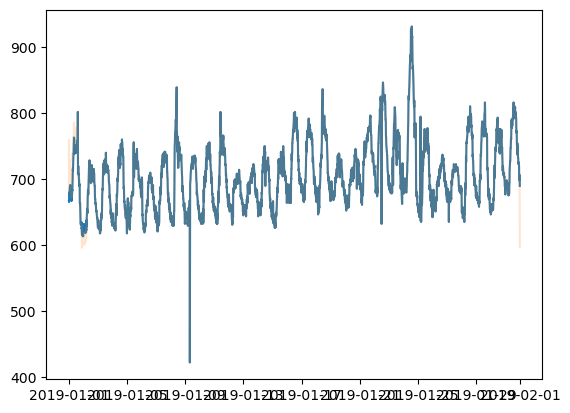

In [18]:
plt.plot(forecast_2019['interval'][0:2976] ,forecast_2019['data'][0:2976])
plt.plot(forecast_2019['interval'][0:2976], (np.array(forecast_2019['data'])-discharge+charge)[0:2976],alpha=.2)

In [19]:
monthly_values_2019['type'] = np.where(monthly_values_2019['battery']=='No', 'No Battery',monthly_values_2019['forecasted_or_actual'] )
monthly_values_2019

,month,forecasted_or_actual,operation_cost,p,e_0,battery,type
0,1,forecasted,299084.715940,1423.595616,0.0,thermal,forecasted
1,1,actual,340245.835695,1856.160000,0.0,thermal,actual
2,1,actual,340186.780800,1856.160000,0.0,No,No Battery
3,2,forecasted,276767.284030,1427.289004,0.0,thermal,forecasted
4,2,actual,310983.530104,1709.280000,0.0,thermal,actual
5,2,actual,310981.161600,1709.280000,0.0,No,No Battery
6,3,forecasted,318995.614944,1458.007879,0.0,thermal,forecasted
7,3,actual,347883.172998,1836.000000,0.0,thermal,actual
8,3,actual,347562.360000,1836.000000,0.0,No,No Battery
9,4,forecasted,305223.641674,1424.871402,0.0,thermal,forecasted


In [27]:
monthly_values_2019_results = monthly_values_2019.pivot(index='month',columns='type', values='operation_cost').reset_index()
monthly_values_2019_results['forecasted_savings'] = monthly_values_2019_results['No Battery'] - monthly_values_2019_results['forecasted']
monthly_values_2019_results['actual_savings'] = monthly_values_2019_results['No Battery'] - monthly_values_2019_results['actual']
monthly_values_2019_results

type,month,No Battery,actual,forecasted,forecasted_savings,actual_savings
0,1,340186.7808,340245.835695,299084.715940,41102.064860,-59.054895
1,2,310981.1616,310983.530104,276767.284030,34213.877570,-2.368504
2,3,347562.3600,347883.172998,318995.614944,28566.745056,-320.812998
3,4,353841.9120,354011.867875,305223.641674,48618.270326,-169.955875
4,5,382922.0784,383266.904650,316080.606812,66841.471588,-344.826250
5,6,545382.6480,545889.553167,431800.636604,113582.011396,-506.905167
6,7,632167.3872,630311.540040,472986.873120,159180.514080,1855.847160
7,8,596644.9488,601020.573034,566343.935903,30301.012897,-4375.624234
8,9,528734.0736,534548.670930,431446.087190,97287.986410,-5814.597330
9,10,395899.9776,396879.035286,355455.994728,40443.982872,-979.057686


In [29]:
monthly_values_2019_results.to_csv('./data/2019_results/forecasted_v_actual_370kw_thermal.csv')